In [1]:
import numpy as np
import itertools
from hmmlearn import hmm
from models_gaussian import StandardGaussianHMM, GaussianDenseHMM, HMMLoggingMonitor, DenseHMMLoggingMonitor
import time
from tqdm import tqdm
from ssm.util import find_permutation
import pickle
import json
from pathlib import Path
import wandb
from utils import dtv, permute_embeddings, compute_stationary,  empirical_coocs
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import erf
from sklearn.cluster import KMeans
import os
import re
from IPython.display import display, Markdown, Latex, HTML
import joblib
import pandas as pd
from sklearn.decomposition import PCA
import multiprocessing as mp
from celluloid import Camera
import matplotlib.cm as cm

2022-08-12 09:21:15.072655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-12 09:21:15.072686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
np.random.seed(2022)

simple_model = {"mu": 10,
                "sigma": 1}

complicated_model = {"mu": 5,
                     "sigma": 2}

EM_ITER = lambda n: 10 * n
TOLERANCE = 5e-5
t = time.localtime()

In [3]:
# list experiments from source
RESULT_DIR = "gaussian_dense_hmm_benchmark/fit_coocs-2022-8-10"

def get_params(s):
    lst = s.split("_")
    s = int(lst[2][1:])
    T = int(lst[3][1:])
    n = int(lst[4][1:])
    simple_model = "True" == lst[6][5:-5]
    return s, T, n, simple_model

results = os.listdir(RESULT_DIR)

param_sets = [get_params(s) for s in results if len(s.split("_")) == 7]

In [4]:
param_sets

[(100, 40, 8, True),
 (100, 400, 4, True),
 (100, 4000, 8, False),
 (100, 4000, 8, True),
 (100, 400, 8, False),
 (100, 40, 20, True),
 (100, 40, 12, True),
 (100, 4000, 20, True),
 (100, 4000, 4, True),
 (100, 4000, 12, True),
 (100, 400, 8, True),
 (100, 40, 8, False),
 (100, 400, 20, True),
 (100, 400, 12, True)]

In [5]:
param_sets

[(100, 40, 8, True),
 (100, 400, 4, True),
 (100, 4000, 8, False),
 (100, 4000, 8, True),
 (100, 400, 8, False),
 (100, 40, 20, True),
 (100, 40, 12, True),
 (100, 4000, 20, True),
 (100, 4000, 4, True),
 (100, 4000, 12, True),
 (100, 400, 8, True),
 (100, 40, 8, False),
 (100, 400, 20, True),
 (100, 400, 12, True)]

In [6]:
def prepare_params(n, simple_model=True):
    A = np.exp(np.random.uniform(0, 5, size=(n, n)))
    A /= A.sum(axis=1)[:, np.newaxis]

    pi = compute_stationary(A)

    if simple_model:
        mu = np.arange(n) * 10
        sigma = np.ones(shape=n)
    else:
        mu = np.random.uniform(0, n * 3, size=n)
        sigma = np.random.uniform(.5, 1.75, size=n)
    return pi, A, mu, sigma


def my_hmm_sampler(pi, A, mu, sigma, T):
    n = pi.shape[0]
    X = [np.random.choice(np.arange(n), 1, replace=True, p=pi)]
    for t in range(T - 1):
        X.append(np.random.choice(np.arange(n), 1, replace=True, p=A[X[t][0], :]))
    Y = np.concatenate([np.random.normal(mu[s[0]], sigma[s[0]], 1) for s in X]).reshape(-1, 1)
    return X, Y


def init_experiment(dsize, simple_model):
    s = dsize[0]
    T = dsize[1]
    n = dsize[2]
    pi, A, mu, sigma = prepare_params(n, simple_model)

    data = [my_hmm_sampler(pi, A, mu, sigma, T) for _ in range(s)]
    X_true = np.concatenate([np.concatenate(y[0]) for y in data])  # states
    Y_true = np.concatenate([x[1] for x in data])  # observations
    lengths = [len(x[1]) for x in data]

    return s, T, n, pi, A, mu, sigma, X_true, Y_true, lengths

In [7]:
def init_experiment(dsize, simple_model):
    s = dsize[0]
    T = dsize[1]
    n = dsize[2]
    pi, A, mu, sigma = prepare_params(n, simple_model)

    data = [my_hmm_sampler(pi, A, mu, sigma, T) for _ in range(s)]
    X_true = np.concatenate([np.concatenate(y[0]) for y in data])  # states
    Y_true = np.concatenate([x[1] for x in data])  # observations
    lengths = [len(x[1]) for x in data]

    EM_ITER_tmp = EM_ITER(n)
    def em_scheduler(max_lr, it):
        if it <= np.ceil(EM_ITER_tmp / 3):
            return max_lr * np.cos(3 * (np.ceil(EM_ITER_tmp / 3) - it) * np.pi * .33 / EM_ITER_tmp)
        else:
            return max_lr * np.cos((it - np.ceil(EM_ITER_tmp / 3)) * np.pi * .66 / EM_ITER_tmp) ** 2

    result = {
        "number_of_sequences": s,
        "sequence_length": T,
        "number_of_hidden_states": n,
        "pi": pi.tolist(),
        "A": A.tolist(),
        "mu": mu.tolist(),
        "sigma": sigma.tolist(),
        "simple_model": simple_model,
        "data": [X_true.tolist(), Y_true.tolist(), lengths],
        "hmmlearn_runs": [],
        "standard_gaussian_runs": [],
        "dense_em_runs": [],
        "dense_cooc_runs": []
    }

    true_values = {
        "states": X_true,
        "transmat": A,
        "startprob": pi,
        "means": mu,
        "covars": sigma
    }

    wandb_params = {
        "init": {
            "project": "gaussian-dense-hmm",
            "entity": "cirglaboratory",  # TODO cirglaboratory
            "save_code": True,
            "group": f"summarise-test-first-fix-{t.tm_year}-{t.tm_mon}-{10}", # t.tm_mday
            "job_type": f"n={n}-s={s}-T={T}-simple={simple_model}",
            "name": f"PDFs",
            "reinit": True
        },
        "config": {
            "n": n,
            "s": s,
            "T": T,
            "model": None,
            "m": None,
            "l": None,
            "lr": 0,
            "em_epochs": 0,
            "em_iter": EM_ITER_tmp,
            "cooc_epochs": 0,
            "epochs": 0,
            "simple_model": simple_model,
            "scheduler": em_scheduler
        }
    }

    run = wandb.init(**wandb_params["init"], config=wandb_params["config"])

    x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3 * max(sigma), 10000)
    for i in range(n):
        plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]), label=str(i))
    plt.title(f"Normal PDFs n={n}-s={s}-T={T}-simple={simple_model}")
    run.log({"Normal densities": wandb.Image(plt)})
    plt.show()

    plt.plot([em_scheduler(1, it) for it in range(EM_ITER_tmp)])
    plt.title("Learning rate schedule")
    run.log({"LR schedule": wandb.Image(plt)})
    plt.show()

    return s, T, n, pi, A, mu, sigma, result, true_values, wandb_params, X_true, Y_true, lengths, data, em_scheduler, run

In [8]:
def draw_embeddings(z, name="?"):
    fig = plt.figure(figsize=(5, 5))
    camera = Camera(fig)
    cmap = cm.rainbow(np.linspace(0, 1, len(z[0])))
    for z_el in z:
        if z_el.shape[1] > 1:
            plt.scatter(z_el[:, 0],  z_el[:, 1], color=cmap)
        else:
            plt.scatter(np.arange(z_el.shape[0]), z_el, color=cmap)
        camera.snap()
    plt.title(f"Embaddings trajectory:  {name}")
    animation = camera.animate()
    wandb.log({f"Embaddings trajectory:  {name}": wandb.Html(animation.to_html5_video())})
    display(HTML(animation.to_html5_video()))
    plt.close()

# n=8, s=100, T=40, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,5,0.007317,84918,0.016798
1,6,0.000870,30336,0.021519
2,8,0.001015,99876,0.010876
3,6,0.000792,31436,0.008832
4,4,0.020602,55440,0.009405
...,...,...,...,...
95,6,0.144247,20967,0.083460
96,6,0.287615,17237,0.074782
97,6,0.248061,14238,0.061664
98,6,0.428404,10827,0.034446


,HMMlearn,DenseCooc
time,4.363,20.267
logprob,-11523.930,-17489.351
acc,1.000,0.775
dtv_transmat,0.042,0.436
dtv_startprob,0.012,0.015
MAE_means,0.026,0.141
MAE_sigma,0.041,36.951


l_param                  5.000000
cooc_lr_param            0.477215
cooc_epochs_param    32796.000000
loss                     0.001946
dtype: float64

wandb: Currently logged in as: kabalce (cirglaboratory). Use `wandb login --relogin` to force relogin


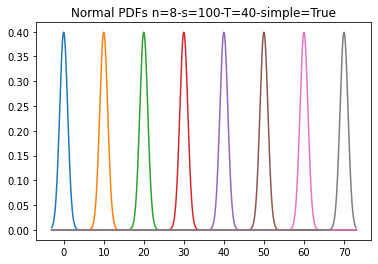

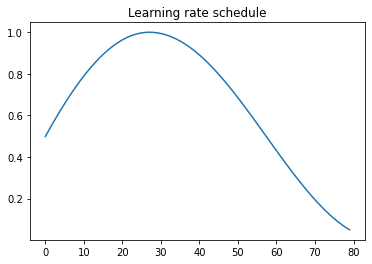

2022-08-12 09:23:05.009924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-12 09:23:05.009966: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-12 09:23:05.009991: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-08-12 09:23:05.010405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 09:23:05.015654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization p

# n=4, s=100, T=400, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,2,0.084394,45616,0.007771
1,2,0.004773,66130,0.031386
2,2,0.240179,23332,0.001834
3,4,0.000853,42942,0.036610
4,4,0.449347,30546,0.002848
...,...,...,...,...
95,2,0.000209,14154,0.074881
96,2,0.000414,12419,0.027982
97,2,0.001361,14697,0.027118
98,2,0.000300,26094,0.034183


,HMMlearn,DenseCooc
time,5.750,59.231
logprob,-100425.566,-158508.265
acc,1.000,0.816
dtv_transmat,0.005,0.456
dtv_startprob,0.012,0.060
MAE_means,0.012,0.015
MAE_sigma,0.009,46.388


l_param                  3.000000
cooc_lr_param            0.024387
cooc_epochs_param    69715.000000
loss                     0.001391
dtype: float64

accuracy,▇▆▆▇▇▇▇▇▇███▇▇▇▆▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
covars_mae,▁▄▄▄▃▃▃▃▃▃▃▄▄▄▅▅▆▆▆▇▇▇███████████
means_mae,▁▂▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇████
omage_dtv,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
total_log_prob,▁▅▆▇▇▇▇▇▇▇▇▇▇████████████████████
transmat_dtv,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.85025
covars_mae,2.85737
means_mae,0.18413


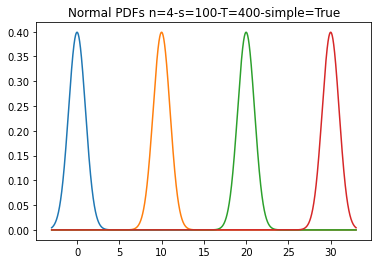

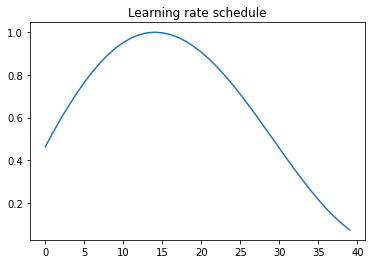

         1     -139021.1522             +nan
         2     -118034.5261      +20986.6260
         3     -111064.1397       +6970.3865
         4     -106680.1790       +4383.9606
         5     -104036.3633       +2643.8157
         6     -102669.4347       +1366.9286
         7     -102069.6607        +599.7740
         8     -101734.0114        +335.6493
         9     -101538.2315        +195.7799
        10     -101411.5376        +126.6939
        11     -101331.8271         +79.7105
        12     -101270.1390         +61.6882
        13     -101217.9410         +52.1979
        14     -101163.9273         +54.0137
        15     -101109.0542         +54.8731
        16     -101048.0541         +61.0001
        17     -100985.6369         +62.4172
        18     -100917.7286         +67.9083
        19     -100850.4030         +67.3256
        20     -100779.6053         +70.7977
        21     -100711.7242         +67.8811
        22     -100642.5719         +69.1523
        23

# n=8, s=100, T=4000, simple=False

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,6,0.033422,97510,0.018442
1,4,0.000745,30449,0.014773


,HMMlearn,DenseCooc
time,117.667,112.972
logprob,-1141134.769,-1320695.381
acc,0.702,0.447
dtv_transmat,0.349,0.458
dtv_startprob,0.028,0.028
MAE_means,1.361,1.717
MAE_sigma,0.806,16.608


l_param                  4.000000
cooc_lr_param            0.000745
cooc_epochs_param    30449.000000
loss                     0.014773
dtype: float64

accuracy,▆██▇▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
covars_mae,▃▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
means_mae,▇██▇▇▇▆▆▅▅▄▄▃▃▃▂▂▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇█
omage_dtv,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,█▆▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▅▇█████████████████████████████████████
transmat_dtv,█▆▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.99805
covars_mae,1.15749
means_mae,0.01294


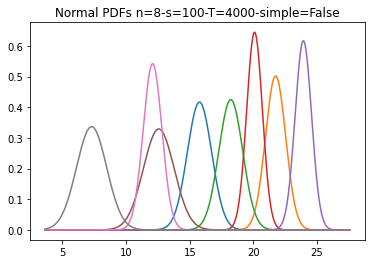

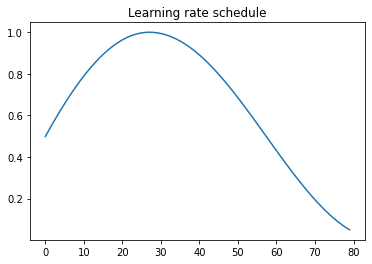

         1    -2474076.7227             +nan
         2    -2468462.8278       +5613.8949
         3    -2462947.3911       +5515.4367
         4    -2457688.5073       +5258.8839
         5    -2452431.8948       +5256.6124
         6    -2447011.6067       +5420.2882
         7    -2441662.1953       +5349.4114
         8    -2436534.4220       +5127.7733
         9    -2431385.0970       +5149.3250
        10    -2426055.0027       +5330.0943
        11    -2420779.3097       +5275.6930
        12    -2415710.9412       +5068.3685
        13    -2410610.9778       +5099.9635
        14    -2405321.2324       +5289.7454
        15    -2400074.9008       +5246.3316
        16    -2395026.3055       +5048.5953
        17    -2389940.2056       +5086.0999
        18    -2384659.8773       +5280.3283
        19    -2379417.2956       +5242.5817
        20    -2374366.2705       +5051.0251
        21    -2369271.7541       +5094.5164
        22    -2363977.6263       +5294.1278
        23

# n=8, s=100, T=4000, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,6,0.218785,38344,0.040166
1,8,0.299599,70154,0.009609
2,6,0.000261,54546,0.040775
3,6,0.000243,69435,0.019716
4,8,0.048283,45702,0.064993
...,...,...,...,...
95,3,0.138263,14955,0.072891
96,3,0.344325,12054,0.075344
97,2,0.090434,26006,0.042902
98,2,0.162511,28901,0.075359


,HMMlearn,DenseCooc
time,182.980,40.503
logprob,-1151710.120,-1731339.684
acc,1.000,0.722
dtv_transmat,0.004,0.521
dtv_startprob,0.015,0.025
MAE_means,0.003,0.171
MAE_sigma,0.004,25.633


l_param                  2.000000
cooc_lr_param            0.326374
cooc_epochs_param    99999.000000
loss                     0.001143
dtype: float64

accuracy,███▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▂
covars_mae,█████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▁▁
means_mae,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████
omage_dtv,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
startprob_dtv,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▄▄▄▄▃▃▃
time,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
total_log_prob,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
transmat_dtv,█████████████████████▇▇▇▁▁▁▁▁▁▁
accuracy,0.6669
covars_mae,0.74113
means_mae,0.44335


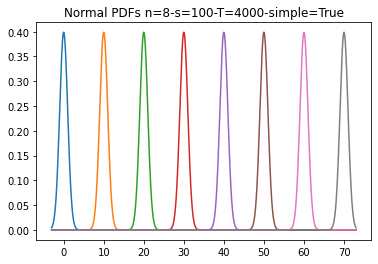

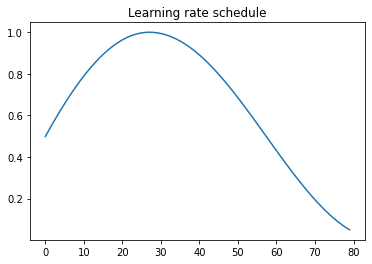

         1    -2366462.3817             +nan
         2    -1929563.4016     +436898.9801
         3    -1780241.1775     +149322.2242
         4    -1742994.8083      +37246.3692
         5    -1743067.5210         -72.7127
         6    -1743536.1342        -468.6132
         7    -1743947.4378        -411.3035
         8    -1744358.8497        -411.4120
         9    -1744720.9506        -362.1009
        10    -1745022.2441        -301.2935
        11    -1745213.7700        -191.5259
        12    -1745200.8228         +12.9472
        13    -1744787.0984        +413.7244
        14    -1743572.2075       +1214.8908
        15    -1741146.8511       +2425.3565
        16    -1737318.5157       +3828.3353
        17    -1731884.6400       +5433.8757
        18    -1725467.2685       +6417.3715
        19    -1720489.8232       +4977.4453
        20    -1718183.2359       +2306.5874
        21    -1717859.9712        +323.2647
        22    -1718773.6606        -913.6894
        23

# n=8, s=100, T=400, simple=False

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,6,0.000168,40789,0.013527
1,6,0.000340,30414,0.014895


,HMMlearn,DenseCooc
time,10.895,30.354
logprob,-113860.674,-146491.680
acc,0.717,0.402
dtv_transmat,0.363,0.584
dtv_startprob,0.030,0.033
MAE_means,1.485,0.667
MAE_sigma,0.739,20.508


l_param                  6.000000
cooc_lr_param            0.000168
cooc_epochs_param    40789.000000
loss                     0.013527
dtype: float64

accuracy,▁▆▇▇▇▇▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▅▅▆▆▇▇▇████████▇▇
covars_mae,▄▇▇▆▆▇██▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃
means_mae,▁▁▂▂▃▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
omage_dtv,█▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,█▆▃▄▄▄▅▄▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
time,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▇███████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆
transmat_dtv,█▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.96988
covars_mae,1.62289
means_mae,0.06829


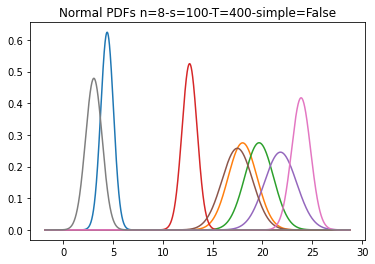

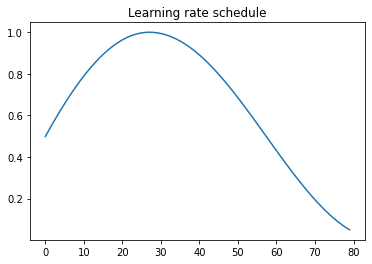

         1     -233408.8120             +nan
         2     -233766.7572        -357.9452
         3     -234078.8939        -312.1367
         4     -234343.2676        -264.3737
         5     -234578.2618        -234.9943
         6     -234793.1060        -214.8442
         7     -234980.6776        -187.5716
         8     -235140.0592        -159.3815
         9     -235282.1408        -142.0816
        10     -235412.2944        -130.1536
        11     -235525.9936        -113.6992
        12     -235622.5147         -96.5211
        13     -235708.3357         -85.8210
        14     -235786.5865         -78.2508
        15     -235854.4614         -67.8749
        16     -235911.5303         -57.0689
        17     -235961.6383         -50.1080
        18     -236006.5628         -44.9244
        19     -236044.6664         -38.1037
        20     -236075.7957         -31.1293
        21     -236102.1287         -26.3330
        22     -236124.5656         -22.4369
        23

# n=20, s=100, T=40, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,13,0.254787,94466,0.310051
1,17,0.001502,18549,0.007644
2,2,0.028573,82085,0.007418
3,5,0.001779,94188,0.004825
4,20,0.004621,22316,0.004760
...,...,...,...,...
95,14,0.218835,34003,0.207342
96,12,0.347359,30773,0.211431
97,16,0.184799,53928,0.062993
98,11,0.441400,88232,0.113454


,HMMlearn,DenseCooc
time,29.239,23.709
logprob,-17179.055,-22214.888
acc,0.813,0.235
dtv_transmat,0.395,0.790
dtv_startprob,0.011,0.024
MAE_means,11.243,19.023
MAE_sigma,23.978,1024.118


l_param                 18.000000
cooc_lr_param            0.011678
cooc_epochs_param    59302.000000
loss                     0.002678
dtype: float64

accuracy,██▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
covars_mae,▁▂▃▃▄▅▅▅▆▆▆▇▇▇▇▇███████████████████▇▇▇▇▇
means_mae,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
omage_dtv,██▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
startprob_dtv,██▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
total_log_prob,█▇▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
transmat_dtv,███▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,0.56893
covars_mae,1.02139
means_mae,1.68891


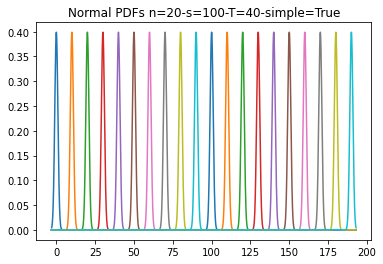

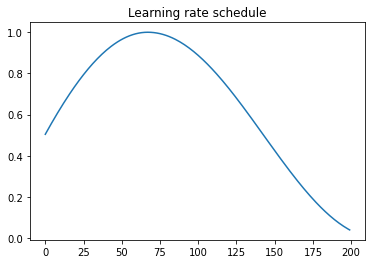

         1      -48382.5493             +nan
         2      -48098.8518        +283.6975
         3      -47904.0204        +194.8314
         4      -47743.8609        +160.1595
         5      -47581.7912        +162.0697
         6      -47438.7226        +143.0686
         7      -47328.9303        +109.7923
         8      -47222.4848        +106.4456
         9      -47112.4374        +110.0473
        10      -47017.1706         +95.2668
        11      -46926.6118         +90.5588
        12      -46829.7900         +96.8218
        13      -46745.7748         +84.0152
        14      -46675.4206         +70.3542
        15      -46602.6809         +72.7397
        16      -46534.1742         +68.5067
        17      -46477.1493         +57.0249
        18      -46419.2034         +57.9460
        19      -46359.0177         +60.1856
        20      -46307.4009         +51.6168
        21      -46258.4419         +48.9590
        22      -46205.1420         +53.2999
        23

# n=12, s=100, T=40, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,7,0.070703,94393,0.052843
1,6,0.000525,80053,0.010136
2,8,0.000224,76065,0.010070
3,11,0.000439,23365,0.085164
4,7,0.002913,42829,0.008368
...,...,...,...,...
95,9,0.200219,15742,0.110864
96,7,0.279065,10063,0.140777
97,7,0.460706,12709,0.186266
98,7,0.469260,10219,0.197302


,HMMlearn,DenseCooc
time,5.674,11.297
logprob,-13829.034,-19407.806
acc,0.930,0.354
dtv_transmat,0.163,0.680
dtv_startprob,0.016,0.014
MAE_means,5.587,6.716
MAE_sigma,2.193,223.011


l_param                  9.000000
cooc_lr_param            0.482015
cooc_epochs_param    62072.000000
loss                     0.004158
dtype: float64

accuracy,▅▃▅▄▆▇██▇▇▇▇▇▇▆▅▅▅▅▅▅▄▂▂▂▂▄▄▄▄▅▄▃▂▂▂▂▁▁▁
covars_mae,▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
means_mae,▃▃▂▂▂▂▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
omage_dtv,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
startprob_dtv,█▆▅▅▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
transmat_dtv,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,0.85175
covars_mae,1.33532
means_mae,0.061


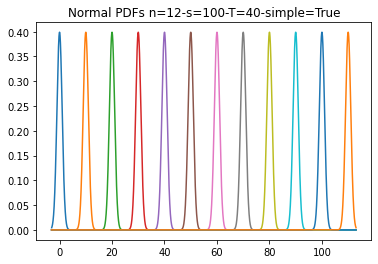

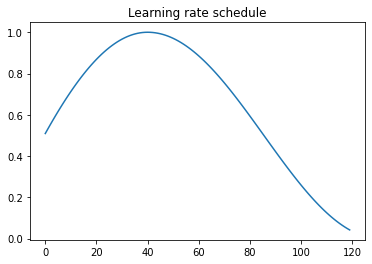

         1      -28898.5425             +nan
         2      -25309.8867       +3588.6559
         3      -24320.1463        +989.7404
         4      -23778.8931        +541.2532
         5      -23430.0726        +348.8205
         6      -23052.2992        +377.7735
         7      -22723.3930        +328.9062
         8      -22394.8832        +328.5098
         9      -22145.1786        +249.7046
        10      -21905.1174        +240.0612
        11      -21733.2249        +171.8925
        12      -21579.9800        +153.2448
        13      -21425.8992        +154.0808
        14      -21233.4430        +192.4562
        15      -21070.6067        +162.8362
        16      -20909.9717        +160.6351
        17      -20781.3544        +128.6173
        18      -20656.0150        +125.3395
        19      -20556.0527         +99.9623
        20      -20444.5203        +111.5324
        21      -20343.2407        +101.2796
        22      -20229.0586        +114.1821
        23

# n=20, s=100, T=4000, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,8,0.016900,62756,0.005504
1,10,0.000122,16913,0.002820
2,7,0.000355,41690,0.003363
3,11,0.008965,22940,0.005279
4,8,0.033231,69961,0.003099
...,...,...,...,...
95,6,0.211670,45893,0.093059
96,6,0.276526,48511,0.231995
97,3,0.415112,38493,0.287744
98,3,0.423795,38931,0.245118


,HMMlearn,DenseCooc
time,1484.422,134.627
logprob,-1696144.029,-2161706.195
acc,0.846,0.240
dtv_transmat,0.308,0.656
dtv_startprob,0.013,0.009
MAE_means,18.314,17.994
MAE_sigma,9.254,780.425


l_param                 18.000000
cooc_lr_param            0.086613
cooc_epochs_param    59599.000000
loss                     0.002597
dtype: float64

accuracy,▆███▇▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
covars_mae,▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
means_mae,▁▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
omage_dtv,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
total_log_prob,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████████████
transmat_dtv,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.8155
covars_mae,9.24893
means_mae,0.44449


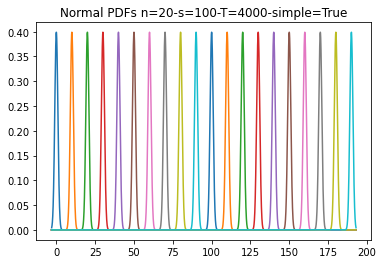

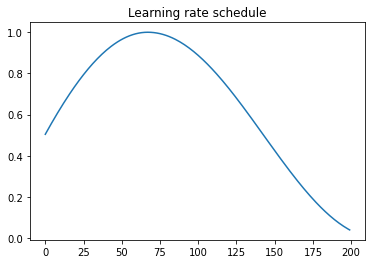

         1    -3969247.3280             +nan
         2    -3859035.6461     +110211.6819
         3    -3802981.1245      +56054.5216
         4    -3771352.7006      +31628.4239
         5    -3741832.3526      +29520.3480
         6    -3715781.6678      +26050.6848
         7    -3694712.4913      +21069.1765
         8    -3674143.4281      +20569.0632
         9    -3653548.0078      +20595.4202
        10    -3635944.8294      +17603.1784
        11    -3618762.1255      +17182.7040
        12    -3599181.6518      +19580.4736
        13    -3580831.0210      +18350.6308
        14    -3564453.7786      +16377.2424
        15    -3546391.4150      +18062.3636
        16    -3528194.3881      +18197.0269
        17    -3511939.1584      +16255.2297
        18    -3493869.6193      +18069.5390
        19    -3473781.1399      +20088.4794
        20    -3458868.1684      +14912.9715
        21    -3446166.5580      +12701.6104
        22    -3432373.0031      +13793.5548
        23

# n=4, s=100, T=4000, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,2,0.005033,17599,0.017364
1,4,0.018186,46726,0.033581
2,4,0.387513,36510,0.004020
3,4,0.259334,51780,0.004265
4,3,0.120679,27516,0.010600
...,...,...,...,...
95,3,0.009124,49630,0.025633
96,4,0.000163,46513,0.029832
97,3,0.067157,63664,0.033511
98,2,0.000305,61406,0.028272


,HMMlearn,DenseCooc
time,37.793,74.796
logprob,-1006051.384,-1712430.312
acc,1.000,0.652
dtv_transmat,0.002,0.647
dtv_startprob,0.035,0.117
MAE_means,0.003,0.008
MAE_sigma,0.005,26.867


l_param                  4.000000
cooc_lr_param            0.157209
cooc_epochs_param    32624.000000
loss                     0.001052
dtype: float64

accuracy,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
covars_mae,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
means_mae,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
omage_dtv,█▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
startprob_dtv,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
transmat_dtv,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,0.78416
covars_mae,3.72712
means_mae,0.02014


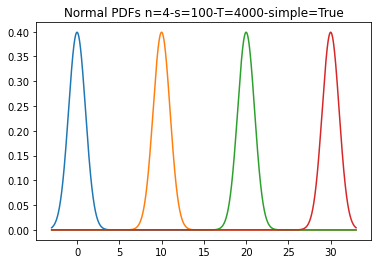

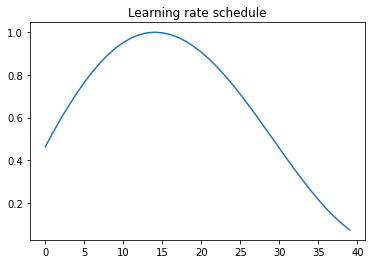

         1    -2890709.2755             +nan
         2    -1580858.8648    +1309850.4107
         3    -1057111.7871     +523747.0778
         4    -1051907.5404       +5204.2467
         5    -1050521.2225       +1386.3178
         6    -1049086.4795       +1434.7430
         7    -1047664.0143       +1422.4652
         8    -1046197.2856       +1466.7288
         9    -1044818.5758       +1378.7097
        10    -1043433.0192       +1385.5567
        11    -1042151.4478       +1281.5714
        12    -1040881.1987       +1270.2491
        13    -1039724.1196       +1157.0792
        14    -1038599.5458       +1124.5738
        15    -1037601.9891        +997.5567
        16    -1036666.8579        +935.1312
        17    -1035876.4433        +790.4147
        18    -1035180.7610        +695.6823
        19    -1034638.3345        +542.4265
        20    -1034207.6415        +430.6930
        21    -1033914.8701        +292.7714
        22    -1033725.6854        +189.1846
        23

# n=12, s=100, T=4000, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,10,0.027441,10574,0.030047
1,10,0.002020,17015,0.010370
2,10,0.000158,46989,0.007031
3,7,0.000247,46052,0.009874
4,6,0.011742,61139,0.012608
...,...,...,...,...
95,4,0.328728,13638,0.119996
96,5,0.000408,18204,0.014898
97,5,0.491667,10000,0.145055
98,4,0.229386,15689,0.089024


,HMMlearn,DenseCooc
time,738.192,21.156
logprob,-1375820.096,-1954071.156
acc,0.940,0.323
dtv_transmat,0.093,0.604
dtv_startprob,0.016,0.023
MAE_means,6.390,8.332
MAE_sigma,4.718,329.451


l_param                  3.000000
cooc_lr_param            0.499089
cooc_epochs_param    70092.000000
loss                     0.001805
dtype: float64

accuracy,▁████████████████████████████████
covars_mae,▁█▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃
means_mae,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
omage_dtv,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
total_log_prob,▁▆███████████████████████████████
transmat_dtv,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.99981
covars_mae,1.17479
means_mae,0.1276


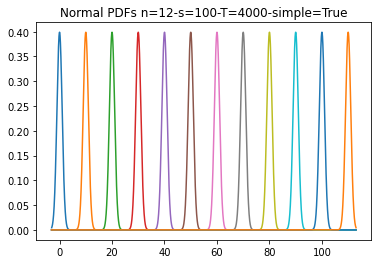

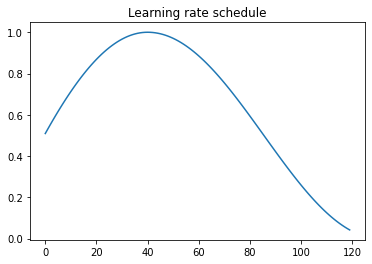

         1    -2304540.5591             +nan
         2    -1989697.9741     +314842.5850
         3    -1900499.0103      +89198.9638
         4    -1854527.2612      +45971.7491
         5    -1829119.5137      +25407.7475
         6    -1807921.8878      +21197.6260
         7    -1790947.2255      +16974.6623
         8    -1772807.0234      +18140.2022
         9    -1763214.2738       +9592.7496
        10    -1758127.3441       +5086.9297
        11    -1754899.9523       +3227.3918
        12    -1751427.9719       +3471.9804
        13    -1747146.5738       +4281.3981
        14    -1740490.6774       +6655.8964
        15    -1733378.6102       +7112.0672
        16    -1724654.1044       +8724.5058
        17    -1716381.4962       +8272.6082
        18    -1706484.2180       +9897.2782
        19    -1696683.8875       +9800.3306
        20    -1683646.1617      +13037.7257
        21    -1670737.4317      +12908.7301
        22    -1662924.1027       +7813.3289
        23

# n=8, s=100, T=400, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,3,0.006093,69449,0.019478
1,5,0.000821,54308,0.017841


,HMMlearn,DenseCooc
time,7.234,67.196
logprob,-114894.435,-172970.389
acc,1.000,0.495
dtv_transmat,0.013,0.510
dtv_startprob,0.010,0.030
MAE_means,0.016,5.013
MAE_sigma,0.019,158.478


l_param                  5.000000
cooc_lr_param            0.000821
cooc_epochs_param    54308.000000
loss                     0.017841
dtype: float64

accuracy,▁▅▇████▅▃▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
covars_mae,▁▁▂▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇████████████████████
means_mae,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
omage_dtv,█▆▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,█▃▂▂▁▁▁▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
total_log_prob,▁▄▆▆▇▇▇▇▇▇▇█████████████████████████████
transmat_dtv,█▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.94868
covars_mae,4.02697
means_mae,0.2694


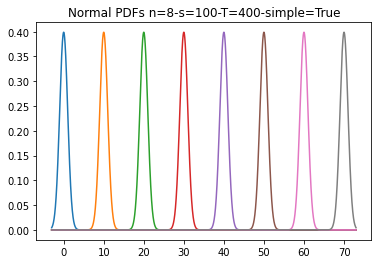

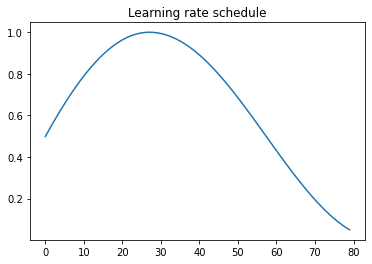

         1     -202185.9987             +nan
         2     -201697.4381        +488.5606
         3     -201213.8347        +483.6034
         4     -200750.7229        +463.1118
         5     -200287.2432        +463.4796
         6     -199810.3775        +476.8658
         7     -199342.7192        +467.6583
         8     -198899.1849        +443.5343
         9     -198460.3531        +438.8318
        10     -198015.0545        +445.2986
        11     -197585.4377        +429.6169
        12     -197185.3666        +400.0711
        13     -196797.4568        +387.9098
        14     -196412.6977        +384.7591
        15     -196050.6519        +362.0459
        16     -195722.0836        +328.5683
        17     -195411.6759        +310.4077
        18     -195111.7793        +299.8966
        19     -194836.6219        +275.1574
        20     -194592.3380        +244.2839
        21     -194365.6004        +226.7376
        22     -194149.3081        +216.2923
        23

# n=8, s=100, T=40, simple=False

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,7,0.015916,41866,0.015953
1,5,0.000292,83168,0.033959


,HMMlearn,DenseCooc
time,2.468,73.447
logprob,-11373.807,-14015.289
acc,0.676,0.334
dtv_transmat,0.310,0.645
dtv_startprob,0.044,0.056
MAE_means,0.808,4.141
MAE_sigma,0.487,34.262


l_param                  7.000000
cooc_lr_param            0.015916
cooc_epochs_param    41866.000000
loss                     0.015953
dtype: float64

accuracy,▁▁▁▁▂▂▂▂▁▂▂▂▂▃▃▃▃▃▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇██████
covars_mae,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
means_mae,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
omage_dtv,████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,██████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
total_log_prob,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
transmat_dtv,███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,0.99767
covars_mae,1.01862
means_mae,0.01273


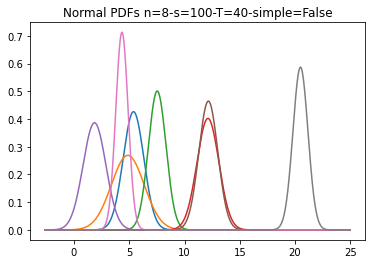

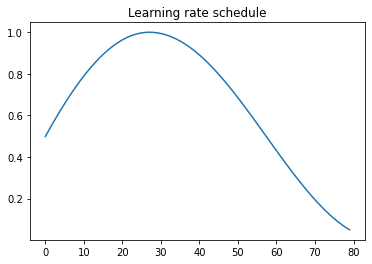

         1      -19626.1433             +nan
         2      -18105.9004       +1520.2430
         3      -17327.8730        +778.0273
         4      -16821.1544        +506.7186
         5      -16442.3960        +378.7584
         6      -16133.1338        +309.2622
         7      -15878.7559        +254.3779
         8      -15667.2939        +211.4620
         9      -15478.1752        +189.1187
        10      -15301.1613        +177.0139
        11      -15141.0150        +160.1463
        12      -14999.0934        +141.9216
        13      -14866.6865        +132.4069
        14      -14739.2530        +127.4335
        15      -14621.8884        +117.3646
        16      -14516.6734        +105.2150
        17      -14417.6549         +99.0185
        18      -14321.6092         +96.0457
        19      -14232.4872         +89.1220
        20      -14152.0149         +80.4723
        21      -14075.7445         +76.2704
        22      -14001.2202         +74.5243
        23

# n=20, s=100, T=400, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,16,0.001724,71486,0.009714
1,2,0.000115,66968,0.005588
2,5,0.000552,76499,0.003368
3,10,0.463195,92646,0.018827
4,17,0.010598,35554,0.008606
...,...,...,...,...
95,12,0.000541,10850,0.004440
96,13,0.399846,61188,0.218416
97,13,0.352646,61193,0.266004
98,13,0.424247,61479,0.329952


,HMMlearn,DenseCooc
time,176.673,84.114
logprob,-168026.996,-216452.159
acc,0.856,0.185
dtv_transmat,0.293,0.796
dtv_startprob,0.013,0.020
MAE_means,11.200,13.995
MAE_sigma,8.322,645.718


l_param                  7.000000
cooc_lr_param            0.043147
cooc_epochs_param    99574.000000
loss                     0.002335
dtype: float64

accuracy,███▇▇▆▆▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
covars_mae,█▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆
means_mae,█▅▃▂▁▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆
omage_dtv,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,█▆▆▅▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃
time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
total_log_prob,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
transmat_dtv,█▇▆▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
accuracy,0.4825
covars_mae,0.74309
means_mae,0.55321


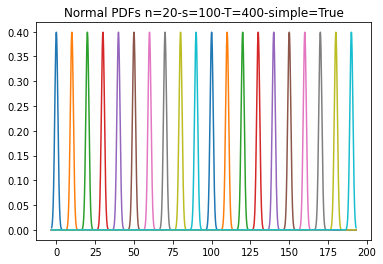

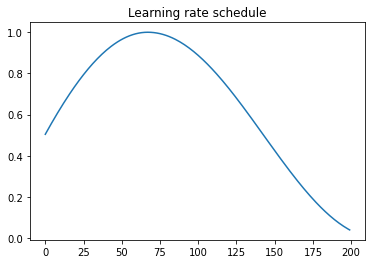

         1     -330029.8808             +nan
         2     -327448.1195       +2581.7613
         3     -325522.7045       +1925.4150
         4     -324011.2807       +1511.4239
         5     -322488.9218       +1522.3589
         6     -321067.1358       +1421.7860
         7     -319882.4601       +1184.6757
         8     -318672.2339       +1210.2262
         9     -317406.1570       +1266.0769
        10     -316314.4750       +1091.6819
        11     -315278.1987       +1036.2763
        12     -314155.9407       +1122.2580
        13     -313149.9732       +1005.9674
        14     -312274.8037        +875.1695
        15     -311339.4327        +935.3710
        16     -310436.0845        +903.3482
        17     -309671.3697        +764.7148
        18     -308884.0599        +787.3098
        19     -308055.6902        +828.3697
        20     -307336.2931        +719.3970
        21     -306645.7627        +690.5304
        22     -305884.1579        +761.6048
        23

# n=12, s=100, T=400, simple=True

,l_param,cooc_lr_param,cooc_epochs_param,loss
0,7,0.006409,55853,0.008470
1,7,0.049245,88321,0.045166
2,12,0.011774,53384,0.013913
3,2,0.000113,23811,0.012923
4,8,0.001086,43188,0.007991
...,...,...,...,...
95,4,0.137090,15289,0.081906
96,2,0.489151,12618,0.106925
97,3,0.176174,19759,0.079121
98,4,0.254608,22459,0.173638


,HMMlearn,DenseCooc
time,48.344,21.257
logprob,-137658.818,-194642.836
acc,0.939,0.420
dtv_transmat,0.140,0.543
dtv_startprob,0.015,0.015
MAE_means,4.122,1.697
MAE_sigma,7.195,254.566


l_param                  2.000000
cooc_lr_param            0.413532
cooc_epochs_param    75962.000000
loss                     0.005748
dtype: float64

accuracy,▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
covars_mae,▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
means_mae,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇██
omage_dtv,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
startprob_dtv,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_log_prob,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
transmat_dtv,██▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,0.9152
covars_mae,3.24487
means_mae,0.02384


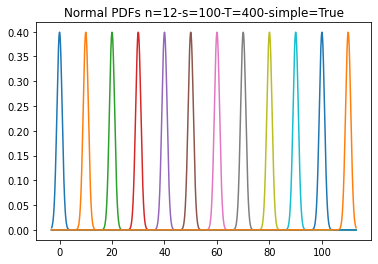

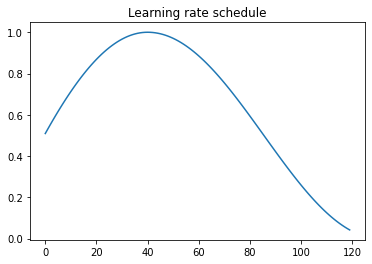

         1     -217773.5432             +nan
         2     -200457.4180      +17316.1251
         3     -189982.0883      +10475.3298
         4     -185365.0719       +4617.0164
         5     -182539.6855       +2825.3864
         6     -180803.4710       +1736.2145
         7     -179270.7401       +1532.7309
         8     -178067.0644       +1203.6757
         9     -177517.6843        +549.3801
        10     -177046.2606        +471.4237
        11     -176716.5433        +329.7173
        12     -176430.6601        +285.8832
        13     -176231.5898        +199.0703
        14     -176052.2437        +179.3461
        15     -175919.9270        +132.3167
        16     -175795.2144        +124.7126
        17     -175700.9788         +94.2356
        18     -175611.5805         +89.3983
        19     -175544.1861         +67.3944
        20     -175480.5629         +63.6232
        21     -175432.7609         +47.8020
        22     -175387.6312         +45.1297
        23

In [9]:
for param in param_sets:
    s, T, n, simple_model = param
    display(Markdown(f"# n={n}, s={s}, T={T}, simple={simple_model}"))
    
    
    
    with open(f"{RESULT_DIR}/optuna_s{s}_T{T}_n{n}_simple_model{simple_model}.pkl",  "rb") as f:
        study = joblib.load(f)
    hyper_param_results = pd.DataFrame([{**trial.params, "loss": trial.values[0]} for trial in study.get_trials()])
    
    with open(f"{RESULT_DIR}/best_result_s{s}_T{T}_n{n}_simple_model{simple_model}.json",  "r") as f:
        best_result = pd.DataFrame(json.load(f))
    
    
    display(hyper_param_results)
    display(best_result.round(3))
    
    params = hyper_param_results.sort_values('loss').iloc[0,  :].to_dict()
    
    display(pd.Series(params))
    
    # TODO: run both model and track embedding trajectories
    s, T, n, pi, A, mu, sigma, result, true_values, wandb_params, X_true, Y_true, lengths, data, em_scheduler, run = init_experiment((s, T, n), simple_model)
    
    run.log({"Tested params": wandb.Table(data=hyper_param_results, columns=hyper_param_results.columns.tolist())})
#     # HMMlearn
#     wandb_params["init"].update({"job_type": f"n={n}-s={s}-T={s}-simple={simple_model}",
#                                  "name": f"HMMlearn"})
#     wandb_params["config"].update(dict(model="HMMlearn", m=0, l=0, lr=0,
#                                        em_iter=EM_ITER(n), cooc_epochs=0,
#                                        epochs=0), scheduler=False, simple_model=simple_model)

#     hmm_monitor = HMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
#                                     wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
#                                     log_config={'metrics_after_convergence': True})
#     hmm_model = hmm.GaussianHMM(n, n_iter=EM_ITER(n))
#     hmm_model.monitor_ = hmm_monitor
#     hmm_model.fit(Y_true, lengths)

#     preds = hmm_model.predict(Y_true, lengths)
#     perm  = find_permutation(preds, X_true)

#     best_result["HMMlearn"] = {
#         "time": time.perf_counter() - hmm_monitor._init_time,
#         "logprob": hmm_model.score(Y_true, lengths),
#         "acc": (X_true == np.array([perm[i] for i in preds])).mean(),
#         "dtv_transmat": dtv(hmm_model.transmat_, A[perm, :][:, perm]),
#         "dtv_startprob": dtv(hmm_model.startprob_, pi[perm]),
#         "MAE_means": (abs(mu[perm] - hmm_model.means_[:, 0])).mean(),
#         "MAE_sigma": (abs(sigma.reshape(-1)[perm] - hmm_model.covars_.reshape(-1))).mean()
#     }

    # Dense HMM
    wandb_params["init"].update({"job_type": f"n={n}-s={s}-T={s}-simple={simple_model}",
                                 "name": f"dense--l={params['l_param']}-lr={params['cooc_lr_param']}-epochs={params['cooc_epochs_param']}"})
    wandb_params["config"].update(dict(model="dense_cooc", m=0, l=params['l_param'], lr=params['cooc_lr_param'],
                                       em_iter=EM_ITER(n), cooc_epochs=params['cooc_epochs_param'],
                                       epochs=params['cooc_epochs_param']), scheduler=True, simple_model=simple_model)

    hmm_monitor = DenseHMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                    wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                    log_config={'metrics_after_convergence': True})
    kmeans = KMeans(n_clusters=n, random_state=0).fit(Y_true)
    nodes_tmp = np.sort(kmeans.cluster_centers_, axis=0)
    nodes = np.concatenate([np.array([-np.infty, Y_true.min()]),
                            (nodes_tmp[1:] + nodes_tmp[:-1]).reshape(-1) / 2,
                            np.array([Y_true.max(), np.infty])])
    m = nodes.shape[0] - 1
    densehmm = GaussianDenseHMM(n, mstep_config={'cooc_epochs': int(params['cooc_epochs_param']),
                                                 'cooc_lr': params['cooc_lr_param'],
                                                 "l_uz": int(params['l_param']),
                                                 'loss_type': 'square',
                                                 'scheduler': em_scheduler},
                                covariance_type='diag', logging_monitor=hmm_monitor, nodes=nodes,
                                init_params="", params="stmc", early_stopping=False, opt_schemes={"cooc"},
                                discrete_observables=m)
    densehmm.fit_coocs(Y_true, lengths)


    preds = densehmm.predict(Y_true, lengths)
    perm = find_permutation(preds, X_true)
    
    best_result["DenseCooc"] = {
        "time": time.perf_counter() - hmm_monitor._init_time,
        "logprob": densehmm.score(Y_true, lengths),
        "acc": (X_true == np.array([perm[i] for i in preds])).mean(),
        "dtv_transmat": dtv(densehmm.transmat_, A[perm, :][:, perm]),
        "dtv_startprob": dtv(densehmm.startprob_, pi[perm]),
        "MAE_means": (abs(mu[perm] - densehmm.means_[:, 0])).mean(),
        "MAE_sigma": (abs(sigma.reshape(-1)[perm] - densehmm.covars_.reshape(-1))).mean()
    }
    z_init = np.transpose(hmm_monitor.z[-1])
    pca_z = PCA(n_components=2).fit(z_init)
    z = [pca_z.transform(np.transpose(x)) for x in hmm_monitor.z] + [pca_z.transform(z_init)]

    z0 = list(hmm_monitor.z0)

    u_init = hmm_monitor.u[-1]
    pca_u = PCA(n_components=2).fit(u_init)
    u = [pca_u.transform(x) for x in hmm_monitor.u] + [pca_u.transform(u_init)]

    draw_embeddings(z, "z")
    draw_embeddings(z0, "z0")
    draw_embeddings(u, "u")